In [1]:
import keras
from keras import backend as K
#MNIST dataset
from keras.datasets import mnist
#Convoluted Neural network related imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#logisitcs regression
from sklearn.linear_model import LogisticRegression
#Random forest 
from sklearn.ensemble import RandomForestClassifier
#KNN
from sklearn.neighbors import KNeighborsClassifier
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Other dependencies
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from __future__ import print_function
from sklearn.metrics import classification_report
from sklearn import datasets
from skimage import exposure
import imutils
import cv2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

%matplotlib notebook


In [2]:
#global variables
column_names = ["Training Set Size", "Logistic Regression - Accuracies", "Neural Network - Accuracies", "K Nearest Neighbour - Accuracies", "Random Forest - Accuracies"]

In [3]:

# load mninst dataset from https://www.openml.org/d/554
def load_mnist():
  mnist = fetch_openml(data_id=554) 
  print (mnist.data.shape, mnist.target.shape)
  return mnist

In [4]:
mnist = load_mnist()

(70000, 784) (70000,)


<IPython.core.display.Javascript object>


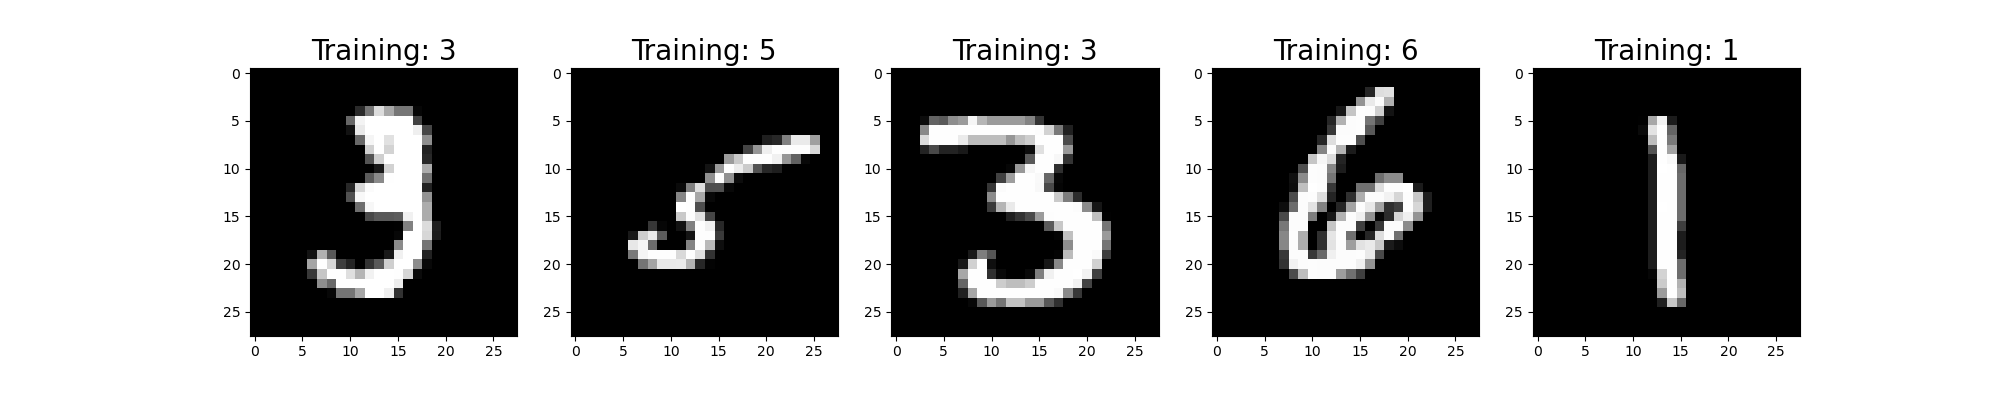

In [5]:
#print some random images and its corresponding labels to verify
def print_images(mnist):
  plt.figure(figsize=(20,4))
  for index, (image, label) in enumerate(zip(mnist.data[10:15], 
                                            mnist.target[10:15])):
      plt.subplot(1, 5, index + 1)
      plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
      plt.title('Training: ' + label, fontsize = 20);

print_images(mnist)  

In [6]:
#prepare data for Convoluted neural network
def prepare_cnn_input(x_train, y_train, x_test, y_test):
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    # normalize so that the pixel values are between 0 and 1
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    # print('x_train shape:', x_train.shape)
    # print(x_train.shape[0], 'train samples')
    # print(x_test.shape[0], 'test samples')
    return x_train, y_train, x_test, y_test

In [7]:
#setup cnn model. we will be using five layers
def setup_cnn_model():
  num_classes = 10
  input_shape = (28, 28, 1)

  #Build model
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

  
  return model

In [8]:
def model_cnn(X_train, X_test, y_train, y_test, model):
  #fit our training set - this will train our model
  model.fit(X_train, y_train, epochs = 10)
  #evaluate the model to see how accurate it is by testing it against test set data   
  score = model.evaluate(X_test, y_test)
  return score

In [9]:
def model_logistics(X_train, X_test, y_train, y_test):
  clf2 = LogisticRegression(fit_intercept=True,
                              multi_class='auto',
                              penalty='l1', #lasso regression
                              solver='saga',
                              max_iter=100,
                              C=50,
                              verbose=1, # output progress
                              n_jobs=5, # parallelize over 5 processes
                              tol=0.01
                              )
  #print (clf2)
  clf2.fit(X_train, y_train)
  clf2.score(X_train, y_train) # training score
  score = clf2.score(X_test, y_test) # test score
  
   
  return score

In [10]:
def model_knn(X_train, X_test, y_train, y_test, k):   
  # train the k-Nearest Neighbor classifier with the current value of `k`
  model = KNeighborsClassifier(n_neighbors = k)
  model.fit(X_train, y_train)

  # evaluate the model and update the accuracies list
  score = model.score(X_test, y_test)
  return score

In [11]:
def model_random_forest(X_train, X_test, y_train, y_test): 
  rfc = RandomForestClassifier(n_jobs=-1, n_estimators=10)
  rfc.fit(X_train, y_train)
  score = rfc.score(X_test, y_test)
  return score

In [12]:
def model_all():
  j = 0
  summary_df = pd.DataFrame(columns = column_names)
  summary_dict = {}
  training_data_set_sizes = []
  logistics_accuracies = []
  cnn_accuracies = []
  knn_accuracies = []
  rcf_accuracies = []
  logistics_score = 0.0
  cnn_score = 0.0
  knn_score = 0.0
  rcf_score = 0.0

  cnn_model = setup_cnn_model();

  for train_dataset_size in range(10,100,10):      
    X_train, X_test, y_train, y_test = train_test_split(np.array(mnist.data), 
                                                        mnist.target.astype('int'), #targets str to int convert
                                                      train_size=(train_dataset_size/100),
                                                      random_state=42)

    training_data_set_sizes.append(X_train.shape[0])
    

    #Fit Logistics regression    
    print("fitting logistic regression model with {:d} training size ".format(X_train.shape[0]))
    logistics_score = model_logistics(X_train, X_test, y_train, y_test)
    logistics_accuracies.append(logistics_score)

    # #Fit knn model    
    print("fitting knn model with {:d} training size ".format(X_train.shape[0]))
    knn_score = model_knn(X_train, X_test, y_train, y_test, 10)
    knn_accuracies.append(knn_score)

    #Fit random forest model    
    print("fitting random forest model with {:d} training size ".format(X_train.shape[0]))
    rcf_score = model_random_forest(X_train, X_test, y_train, y_test)
    rcf_accuracies.append(rcf_score)

    #Fit CNN model    
    print("fitting cnn model with {:d} training size ".format(X_train.shape[0]))
    X_train, y_train, X_test, y_test = prepare_cnn_input(X_train, y_train, X_test, y_test)
    cnn_score = model_cnn(X_train, X_test, y_train, y_test, cnn_model)
    cnn_accuracies.append(cnn_score[1])

    print(X_train.shape[0], logistics_score*100, knn_score*100, rcf_score*100, cnn_score[1]* 100)
      

  #prepare data for furhter analysis  
  summary_dict = {column_names[0]:training_data_set_sizes, 
                  column_names[1]:logistics_accuracies,
                  column_names[2]:cnn_accuracies,
                  column_names[3]:knn_accuracies,
                  column_names[4]:rcf_accuracies}
  df = pd.DataFrame(summary_dict)   
  print(df) 
  return df

In [13]:
summary_df = model_all()
summary_df.to_csv ("output.csv", index = False, header=True)
#print("Training set size = {:d}  Logistics Regression Accuracy = {:.2f}%  CNN Accuracy = {:.2f}%".format(7000, .2*100, .3* 100))


fitting logistic regression model with 7000 training size 


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 49 epochs took 50 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   49.6s finished


fitting knn model with 7000 training size 
fitting random forest model with 7000 training size 
fitting cnn model with 7000 training size 
Epoch 1/10
219/219 [==============================] - 5s 23ms/step - loss: 2.3128 - accuracy: 0.0946 2s - loss:
Epoch 2/10
219/219 [==============================] - 6s 28ms/step - loss: 2.3085 - accuracy: 0.1011
Epoch 3/10
219/219 [==============================] - 6s 29ms/step - loss: 2.3036 - accuracy: 0.1026
Epoch 4/10
219/219 [==============================] - 5s 23ms/step - loss: 2.2998 - accuracy: 0.1127
Epoch 5/10
219/219 [==============================] - 6s 26ms/step - loss: 2.2948 - accuracy: 0.1174
Epoch 6/10
219/219 [==============================] - 6s 26ms/step - loss: 2.2919 - accuracy: 0.1293
Epoch 7/10
219/219 [==============================] - 6s 27ms/step - loss: 2.2879 - accuracy: 0.1304 0s - loss: 2.288
Epoch 8/10
219/219 [==============================] - 6s 27ms/step - loss: 2.2845 - accuracy: 0.1416
Epoch 9/10
219/219 [=====

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 42 epochs took 142 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.4min finished


fitting knn model with 14000 training size 
fitting random forest model with 14000 training size 
fitting cnn model with 14000 training size 
Epoch 1/10
438/438 [==============================] - 9s 20ms/step - loss: 2.2719 - accuracy: 0.1626 2s - - ETA: 0s - loss: 2.2
Epoch 2/10
438/438 [==============================] - 10s 23ms/step - loss: 2.2639 - accuracy: 0.17720s - loss: 2.2639 - accuracy: 
Epoch 3/10
438/438 [==============================] - 9s 21ms/step - loss: 2.2550 - accuracy: 0.1936
Epoch 4/10
438/438 [==============================] - 10s 22ms/step - loss: 2.2457 - accuracy: 0.2070
Epoch 5/10
438/438 [==============================] - 10s 23ms/step - loss: 2.2372 - accuracy: 0.2159
Epoch 6/10
438/438 [==============================] - 10s 23ms/step - loss: 2.2286 - accuracy: 0.2249
Epoch 7/10
438/438 [==============================] - 11s 25ms/step - loss: 2.2187 - accuracy: 0.24501s - loss: 2.2199 - accuracy: 0. - ETA: 0s - l
Epoch 8/10
438/438 [=======================

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 34 epochs took 99 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  1.6min finished


fitting knn model with 21000 training size 
fitting random forest model with 21000 training size 
fitting cnn model with 21000 training size 
Epoch 1/10
657/657 [==============================] - 12s 19ms/step - loss: 2.1729 - accuracy: 0.2771
Epoch 2/10
657/657 [==============================] - 12s 19ms/step - loss: 2.1568 - accuracy: 0.2885
Epoch 3/10
657/657 [==============================] - 13s 19ms/step - loss: 2.1368 - accuracy: 0.2978
Epoch 4/10
657/657 [==============================] - 13s 19ms/step - loss: 2.1158 - accuracy: 0.31200s - loss: 2.1157 - accuracy: 0.
Epoch 5/10
657/657 [==============================] - 13s 19ms/step - loss: 2.0943 - accuracy: 0.3239
Epoch 6/10
657/657 [==============================] - 13s 19ms/step - loss: 2.0757 - accuracy: 0.32760s - los
Epoch 7/10
657/657 [==============================] - 13s 19ms/step - loss: 2.0474 - accuracy: 0.3443
Epoch 8/10
657/657 [==============================] - 12s 19ms/step - loss: 2.0235 - accuracy: 0.3575
Ep

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 37 epochs took 135 seconds
fitting knn model with 28000 training size 

[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.3min finished



fitting random forest model with 28000 training size 
fitting cnn model with 28000 training size 
Epoch 1/10
875/875 [==============================] - 17s 19ms/step - loss: 1.9426 - accuracy: 0.3870
Epoch 2/10
875/875 [==============================] - 16s 19ms/step - loss: 1.9005 - accuracy: 0.4031
Epoch 3/10
875/875 [==============================] - 17s 19ms/step - loss: 1.8606 - accuracy: 0.41540s - l
Epoch 4/10
875/875 [==============================] - 17s 19ms/step - loss: 1.8222 - accuracy: 0.4275
Epoch 5/10
875/875 [==============================] - 16s 19ms/step - loss: 1.7797 - accuracy: 0.4462
Epoch 6/10
875/875 [==============================] - 16s 19ms/step - loss: 1.7379 - accuracy: 0.4571
Epoch 7/10
875/875 [==============================] - 16s 19ms/step - loss: 1.7004 - accuracy: 0.4669
Epoch 8/10
875/875 [==============================] - 16s 19ms/step - loss: 1.6607 - accuracy: 0.4774
Epoch 9/10
875/875 [==============================] - 16s 19ms/step - loss: 1.6

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 50 epochs took 238 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  4.0min finished


fitting knn model with 35000 training size 
fitting random forest model with 35000 training size 
fitting cnn model with 35000 training size 
Epoch 1/10
1094/1094 [==============================] - 19s 17ms/step - loss: 1.5492 - accuracy: 0.5110
Epoch 2/10
1094/1094 [==============================] - 19s 17ms/step - loss: 1.5057 - accuracy: 0.5247
Epoch 3/10
1094/1094 [==============================] - 19s 18ms/step - loss: 1.4641 - accuracy: 0.5382
Epoch 4/10
1094/1094 [==============================] - 20s 18ms/step - loss: 1.4244 - accuracy: 0.5461
Epoch 5/10
1094/1094 [==============================] - 21s 19ms/step - loss: 1.3834 - accuracy: 0.56170s - loss: 1.3829 - ac
Epoch 6/10
1094/1094 [==============================] - 20s 19ms/step - loss: 1.3615 - accuracy: 0.5659
Epoch 7/10
1094/1094 [==============================] - 20s 18ms/step - loss: 1.3218 - accuracy: 0.5750
Epoch 8/10
1094/1094 [==============================] - 20s 18ms/step - loss: 1.2847 - accuracy: 0.5907
Epoc

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 54 epochs took 291 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  4.8min finished


fitting knn model with 42000 training size 
fitting random forest model with 42000 training size 
fitting cnn model with 42000 training size 
Epoch 1/10
1313/1313 [==============================] - 25s 19ms/step - loss: 1.2007 - accuracy: 0.6174
Epoch 2/10
1313/1313 [==============================] - 25s 19ms/step - loss: 1.1582 - accuracy: 0.6317
Epoch 3/10
1313/1313 [==============================] - 25s 19ms/step - loss: 1.1334 - accuracy: 0.63931s - ETA: 0s - l
Epoch 4/10
1313/1313 [==============================] - 26s 20ms/step - loss: 1.1065 - accuracy: 0.64820s - loss: 1.1069 - accura
Epoch 5/10
1313/1313 [==============================] - 28s 21ms/step - loss: 1.0783 - accuracy: 0.6520
Epoch 6/10
1313/1313 [==============================] - 28s 21ms/step - loss: 1.0621 - accuracy: 0.66142s - loss: 1
Epoch 7/10
1313/1313 [==============================] - 27s 20ms/step - loss: 1.0377 - accuracy: 0.6684
Epoch 8/10
1313/1313 [==============================] - 26s 20ms/step - loss

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 44 epochs took 272 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  4.5min finished


fitting knn model with 49000 training size 
fitting random forest model with 49000 training size 
fitting cnn model with 49000 training size 
Epoch 1/10
1532/1532 [==============================] - 30s 20ms/step - loss: 0.9531 - accuracy: 0.6950
Epoch 2/10
1532/1532 [==============================] - 30s 19ms/step - loss: 0.9298 - accuracy: 0.7042
Epoch 3/10
1532/1532 [==============================] - 30s 20ms/step - loss: 0.9116 - accuracy: 0.7098
Epoch 4/10
1532/1532 [==============================] - 31s 20ms/step - loss: 0.8862 - accuracy: 0.7180
Epoch 5/10
1532/1532 [==============================] - 30s 20ms/step - loss: 0.8733 - accuracy: 0.7254
Epoch 6/10
1532/1532 [==============================] - 31s 20ms/step - loss: 0.8489 - accuracy: 0.7307
Epoch 7/10
1532/1532 [==============================] - 31s 20ms/step - loss: 0.8359 - accuracy: 0.7351
Epoch 8/10
1532/1532 [==============================] - 31s 20ms/step - loss: 0.8212 - accuracy: 0.74180s - loss: 0
Epoch 9/10
153

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 58 epochs took 413 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  6.9min finished


fitting knn model with 56000 training size 
fitting random forest model with 56000 training size 
fitting cnn model with 56000 training size 
Epoch 1/10
1750/1750 [==============================] - 34s 19ms/step - loss: 0.7778 - accuracy: 0.7541
Epoch 2/10
1750/1750 [==============================] - 34s 20ms/step - loss: 0.7610 - accuracy: 0.7615
Epoch 3/10
1750/1750 [==============================] - 36s 21ms/step - loss: 0.7460 - accuracy: 0.7651
Epoch 4/10
1750/1750 [==============================] - 37s 21ms/step - loss: 0.7280 - accuracy: 0.7712
Epoch 5/10
1750/1750 [==============================] - 36s 21ms/step - loss: 0.7128 - accuracy: 0.77630s - loss: 0.7127 - accura
Epoch 6/10
1750/1750 [==============================] - 36s 20ms/step - loss: 0.7057 - accuracy: 0.7806
Epoch 7/10
1750/1750 [==============================] - 37s 21ms/step - loss: 0.6929 - accuracy: 0.7836
Epoch 8/10
1750/1750 [==============================] - 36s 21ms/step - loss: 0.6832 - accuracy: 0.7869


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 53 epochs took 424 seconds
fitting knn model with 63000 training size 


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  7.1min finished


fitting random forest model with 63000 training size 
fitting cnn model with 63000 training size 
Epoch 1/10
1969/1969 [==============================] - 37s 19ms/step - loss: 0.6465 - accuracy: 0.7974
Epoch 2/10
1969/1969 [==============================] - 37s 19ms/step - loss: 0.6399 - accuracy: 0.8020
Epoch 3/10
1969/1969 [==============================] - 38s 19ms/step - loss: 0.6255 - accuracy: 0.8069
Epoch 4/10
1969/1969 [==============================] - 38s 19ms/step - loss: 0.6137 - accuracy: 0.8113
Epoch 5/10
1969/1969 [==============================] - 38s 19ms/step - loss: 0.6059 - accuracy: 0.8151
Epoch 6/10
1969/1969 [==============================] - 38s 20ms/step - loss: 0.5981 - accuracy: 0.81680s - loss: 0.5980 - accuracy: 
Epoch 7/10
1969/1969 [==============================] - 38s 19ms/step - loss: 0.5825 - accuracy: 0.8195
Epoch 8/10
1969/1969 [==============================] - 38s 19ms/step - loss: 0.5771 - accuracy: 0.8228
Epoch 9/10
1969/1969 [==================

In [14]:
summary_df

,Training Set Size,Logistic Regression - Accuracies,Neural Network - Accuracies,K Nearest Neighbour - Accuracies,Random Forest - Accuracies
0,7000,0.899095,0.238508,0.933571,0.896619
1,14000,0.908250,0.504375,0.947018,0.917125
2,21000,0.912816,0.635184,0.954857,0.927857
3,28000,0.915405,0.756619,0.958881,0.934286
4,35000,0.919657,0.823257,0.961914,0.938286
5,42000,0.919214,0.867750,0.963964,0.940250
6,49000,0.919905,0.898238,0.964714,0.943714
7,56000,0.920357,0.918571,0.965786,0.946286
8,63000,0.921143,0.928286,0.966143,0.947000


<ipython-input-19-92db296f97f1>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


[Text(0, 0.2, '20.00%'),
 Text(0, 0.30000000000000004, '30.00%'),
 Text(0, 0.4, '40.00%'),
 Text(0, 0.5, '50.00%'),
 Text(0, 0.6000000000000001, '60.00%'),
 Text(0, 0.7, '70.00%'),
 Text(0, 0.8, '80.00%'),
 Text(0, 0.9000000000000001, '90.00%'),
 Text(0, 1.0, '100.00%'),
 Text(0, 1.1, '110.00%')]

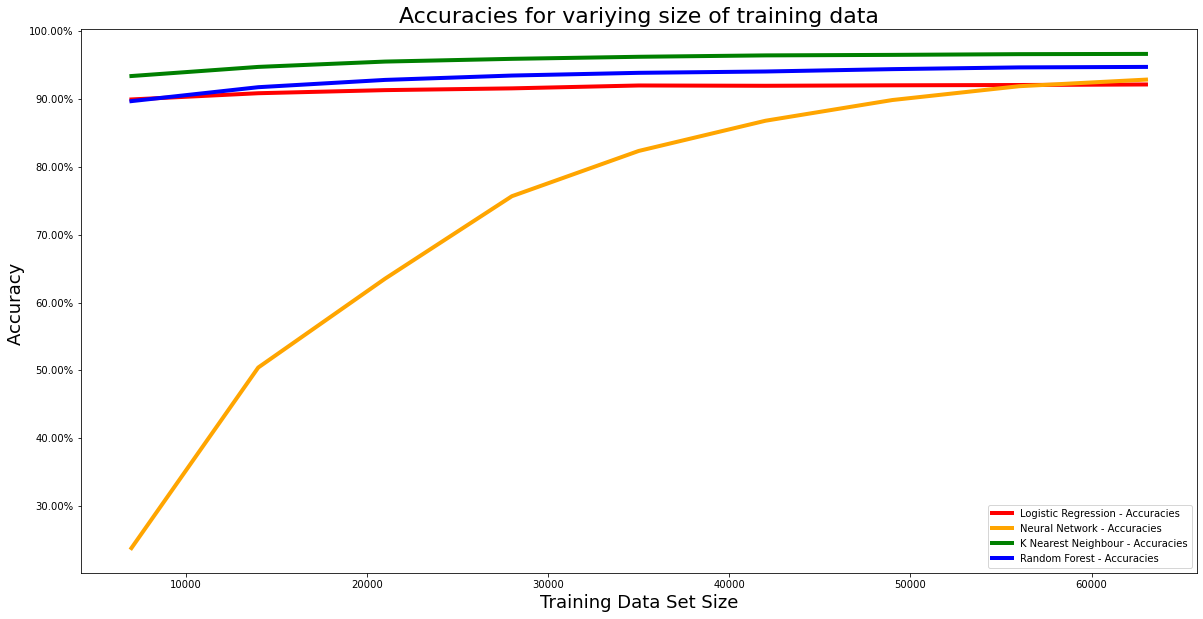

In [19]:
%matplotlib notebook
%matplotlib inline
plt.figure(figsize=(20,10))

ax = plt.gca()
summary_df.plot(kind='line',x='Training Set Size',y='Logistic Regression - Accuracies', color='red', linewidth=4, ax=ax)
summary_df.plot(kind='line',x='Training Set Size',y='Neural Network - Accuracies', color='orange', linewidth=4, ax=ax)
summary_df.plot(kind='line',x='Training Set Size',y='K Nearest Neighbour - Accuracies', color='green', linewidth=4, ax=ax)
summary_df.plot(kind='line',x='Training Set Size',y='Random Forest - Accuracies', color='blue', linewidth=4, ax=ax)
plt.xlabel("Training Data Set Size", fontsize=18)
plt.ylabel("Accuracy ", fontsize=18)
plt.title("Accuracies for variying size of training data", fontsize=22)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
